<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Time-Series-Forecasting/blob/main/20231217_EDA_Sara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Project Detail

**Problem:** Time Series Forecasting

**Goal:** The task is to develop a forecasting model that is able to predict several uncorrelated time series. The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

**Dataset Detail:**


1.   Time series length: the length of the time series in the training dataset is variable. To simplify the portability of the dataset, we padded with zeros the sequences to the maximum length of 2776. Thus, the dataset is provided in a compact form as a Nx2776 array. We provide an additional 'valid_periods.npy' file containing the information to recover the original time series without the padding
2.   File Format: npy

3.   Categories: the provided time series are composed by sequences collected from 6 different sources. We further provide additional information about the category of each time series.


**Datas Structure:** Single folder containing the following files:
1. 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
2. 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
3. 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
`IMPORTANT:` This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set. To download `**datset**`, click on the link below: [link](https://drive.google.com/drive/folders/1LntbkzHK04CtRrXl8s9U62FH6V2VFkce?usp=sharing) and for `**github repositoy**` please click on this: [Link](https://github.com/Mohammad-Amirifard/Time-Series-Forecasting)

**Notebook 1:** In this notebook we are trying to do the first analyses on datas. Notebook 2 is dedicated for model choesed based on problem.

###1- Connect Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive to /content directory. You can see your drive on the left pannel.

Mounted at /content/drive


In [2]:
# Please replace dataset_directory with yours.
project_directory = "/content/drive/MyDrive/Time_Series/Dataset/training_dataset.zip"
%cp -r {project_directory} /content

###2- Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import pandas as pd


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
from math import sqrt
from statsmodels.tsa.stattools import kpss
import seaborn as sns
%matplotlib inline

###3- Load data

In [4]:
# Unzip dataset to /content direcory. Please replace the dataset_dir with yours in you drive.
!unzip -qq '/content/training_dataset.zip' -d '/content'

In [5]:
# Load different datasets
categories = np.load('/content/categories.npy')
training_data = np.load('/content/training_data.npy')
valid_periods = np.load('/content/valid_periods.npy')

### 4- EDA

####4-1 First info of Datasets

In [6]:
print(f'training_data.shape: {training_data.shape}')
print(f'categories.shape: {categories.shape}')
print(f'valid_periods.shape: {valid_periods.shape}')

training_data.shape: (48000, 2776)
categories.shape: (48000,)
valid_periods.shape: (48000, 2)


In [7]:
# Create Dataframe for each for a better view
training_data_df = pd.DataFrame(training_data.astype(np.float16))
categories_df = pd.DataFrame(categories,columns=['Category'])
valid_periods_df = pd.DataFrame(valid_periods,columns=['Start index','End index'])


# Create a dataset without padding values, using valid period dataset
data_without_padding = []
for i, (start, end) in enumerate(valid_periods):
    data_without_padding.append(training_data[i, start:end])

data_without_padding_df = pd.DataFrame(data_without_padding)

In [9]:
data_without_padding_df.head() # Show  first 5 time series

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.491667,0.524074,0.544444,0.463889,0.406481,0.354630,0.312963,0.366667,0.383333,0.279630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480000,0.500000,0.588000,0.420000,0.288000,0.300000,0.288000,0.516000,0.560000,0.564000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007404,0.000000,0.017955,0.020916,0.027580,0.029246,0.023045,0.024988,0.019250,0.018973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000,0.929699,0.652798,0.678623,0.572453,0.598278,0.657102,0.738881,0.558106,0.641320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.204545,0.386364,0.295455,0.454545,0.454545,0.477273,0.454545,0.318182,0.227273,0.318182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
categories_df.head()

,Category
0,D
1,D
2,D
3,D
4,D


In [11]:
valid_periods_df.head()

,Start index,End index
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776


####4-2 Plot Function

In [12]:
# Here we show just only 5 time series together.
def plot_graphs(no_graphs=5,row_start_from = 0,show_outliers = False, upper_outliers = None, lower_outliers=None):

  figure = plt.figure(figsize=(15,7))

  for i in range(no_graphs):

    # Find start and end points of ith time series from valid_perods_df
    start_point = valid_periods_df.iloc[row_start_from + i,0]
    end_point = valid_periods_df.iloc[row_start_from + i,1]
    sns.lineplot(x=np.arange(start_point,end_point), y=training_data_df.iloc[row_start_from + i,start_point:end_point], label=f'time_series_{row_start_from + i}_With_Category_{list(categories_df.iloc[row_start_from + i])[0]}')
    # pay attention : lineplot for large range automatically performs data sampling to improve visualization performance.Hence, maybe you see some outliers are out of lines. But actually they are avaiable.
  if show_outliers :
    if upper_outliers is None:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
    elif lower_outliers is None:
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')
    else:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title(f'Line graph')
  plt.show()


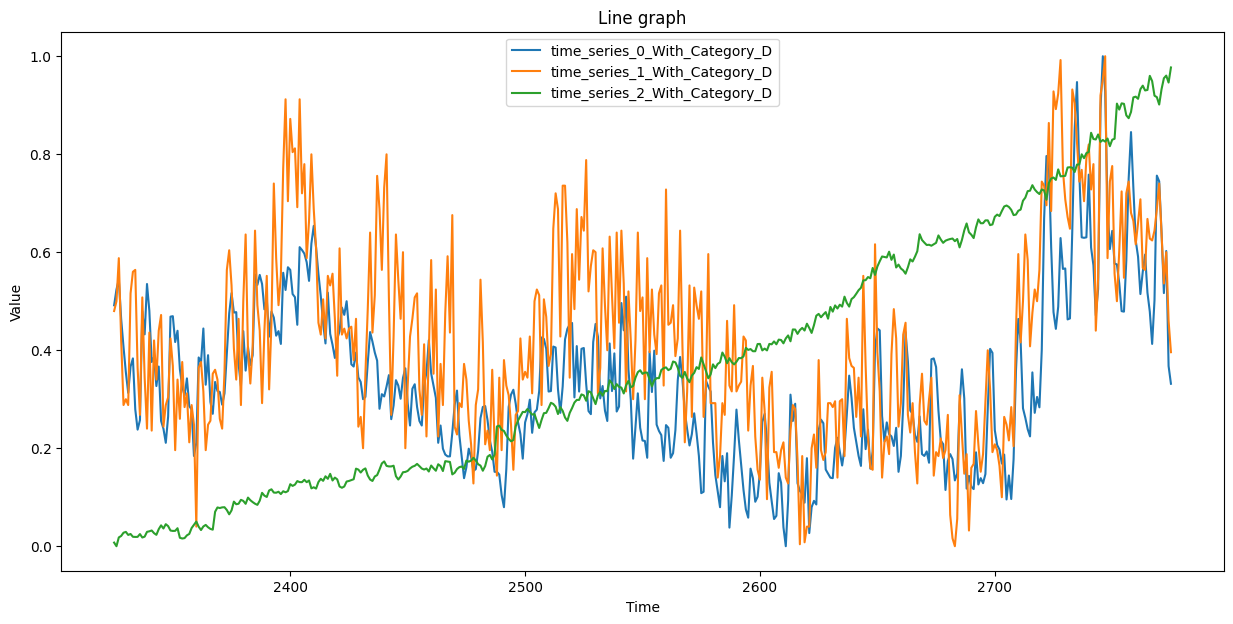

In [13]:
plot_graphs(no_graphs=3,row_start_from=0)

####4-3 Check outliers
Here, we find outliers of each time series

In [14]:
import pandas as pd

# Function to detect outliers in a time series based on IQR
def detect_outliers(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((series < lower_bound) | (series > upper_bound))

# Applying the outlier detection function to each time series
outliers_indices = [detect_outliers(training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]) for i in tqdm(range(len(training_data)))]


# Counting the number of outliers in each time series
outliers_count = [len(outliers[0]) for outliers in outliers_indices]

# Creating a DataFrame for better visualization
outliers_df = pd.DataFrame({'Time Series': range(len(training_data)), 'Outliers Count': outliers_count})
outliers_df.head()

100%|██████████| 48000/48000 [00:13<00:00, 3555.46it/s]


,Time Series,Outliers Count
0,0,8
1,1,2
2,2,0
3,3,0
4,4,0


####4-4 Plot graphs with outliers

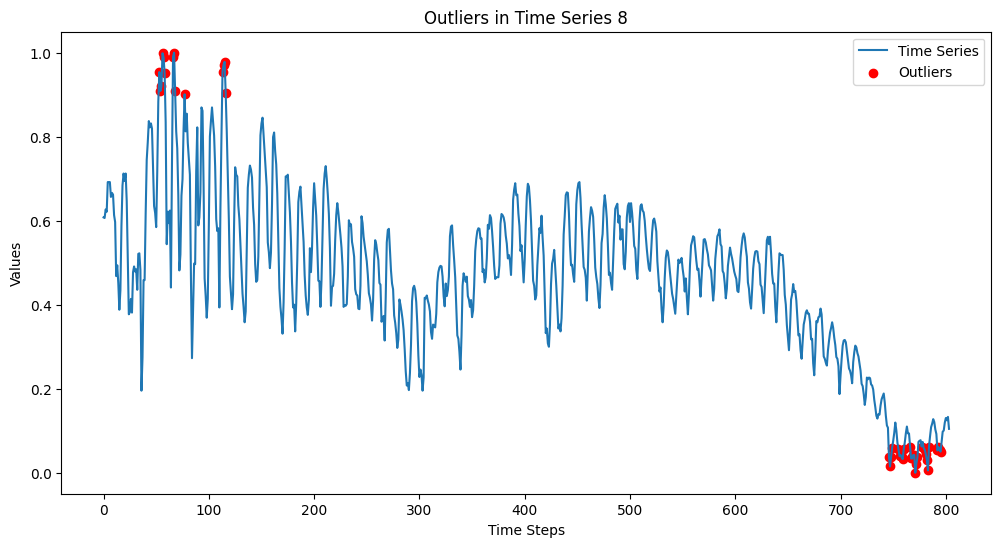

In [15]:
def plot_outliers(time_series_index):
    series = training_data[time_series_index, valid_periods[time_series_index, 0]:valid_periods[time_series_index, 1]]
    outliers = outliers_indices[time_series_index]

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Time Series')
    plt.scatter(outliers, series[outliers], color='red', label='Outliers')
    plt.title(f'Outliers in Time Series {time_series_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Plotting outliers for the first time series as an example


plot_outliers(8)

####4-6 Winsorizng outliers

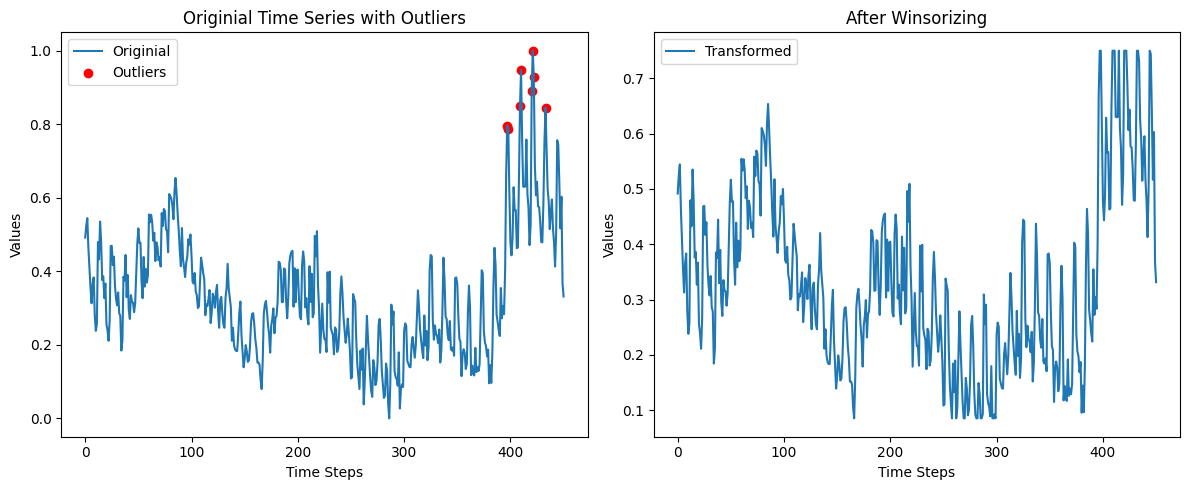

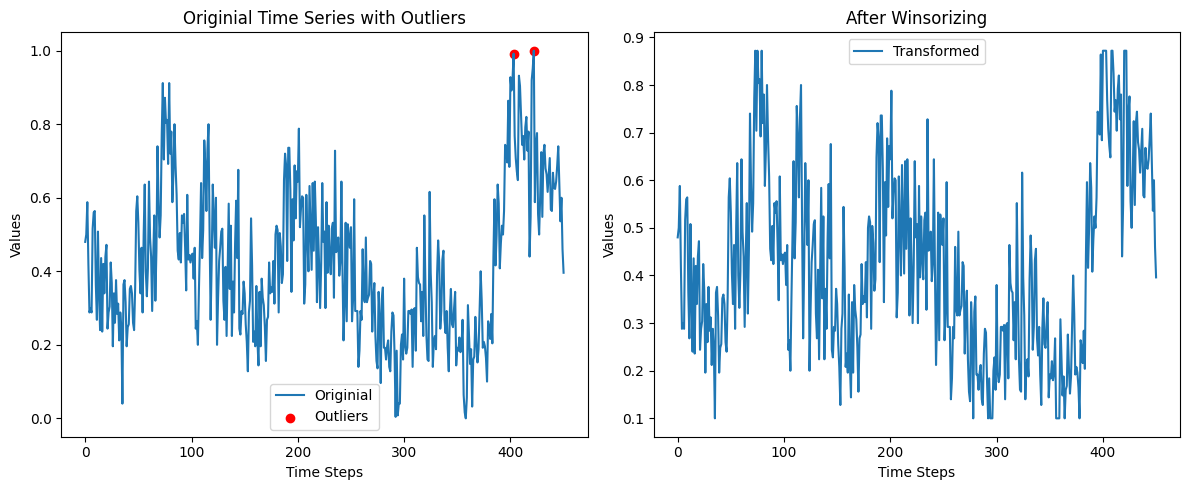

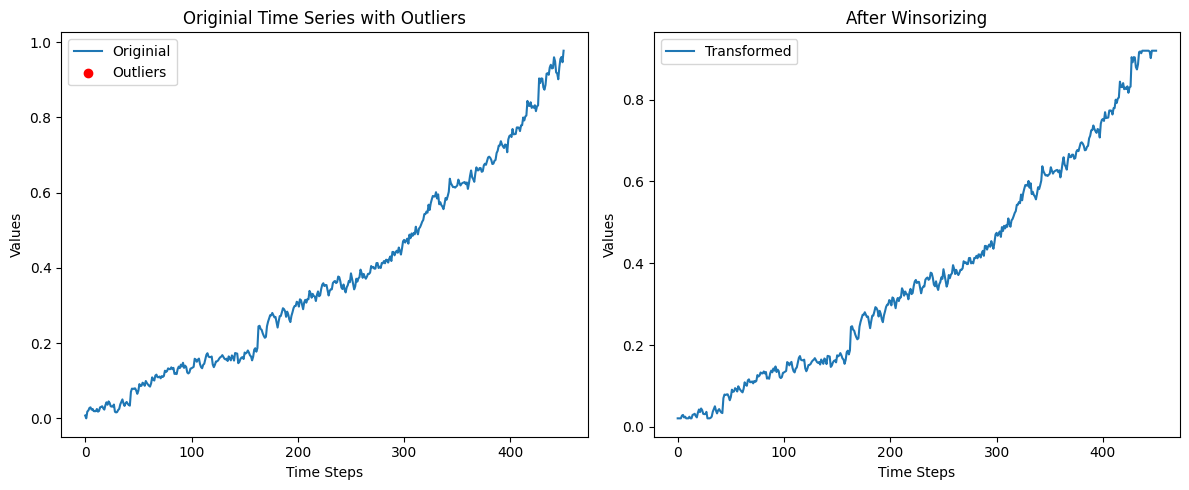

In [16]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler


def robust_scale_series(series):
    scaler = RobustScaler()
    return scaler.fit_transform(series.reshape(-1, 1)).flatten()

def winsorize_series(series, limits=[0.025, 0.025]):
    return winsorize(series, limits=limits)

def plot_series_before_after(series,label, method='robust'):
    plt.figure(figsize=(12, 5))

    # Original series with outliers
    plt.subplot(1, 2, 1)
    plt.plot(series, label=label)
    outliers = detect_outliers(series)
    plt.scatter(outliers, series[outliers], color='red', label='Outliers')
    plt.title(f'{label} Time Series with Outliers')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    # Series after transformation
    plt.subplot(1, 2, 2)
    if method == 'robust':
        transformed_series = robust_scale_series(series)
        plt.title('After Robust Scaling')
    elif method == 'winsorize':
        transformed_series = winsorize_series(series)
        plt.title('After Winsorizing')

    plt.plot(transformed_series, label='Transformed')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example: Plotting for the first few time series
for i in range(3):
    series = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    plot_series_before_after(series,label='Originial', method='winsorize')  # Change to 'winsorize' or 'robust' if needed

In [18]:
# Now Let's remove outliers by winsorizing mehtod and have new dataset

winsorized_training_data1 = training_data.copy()
for i in tqdm(range(48000)):
    series = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    winsorized_series = winsorize_series(series)
    winsorized_training_data1[i, valid_periods[i, 0]:valid_periods[i, 1]] = winsorized_series

100%|██████████| 48000/48000 [00:15<00:00, 3067.89it/s]


####4-7 Robusting method for normalizing
Robusting raw data+ finding its otuliers + winsorizing

100%|██████████| 48000/48000 [00:51<00:00, 932.85it/s] 


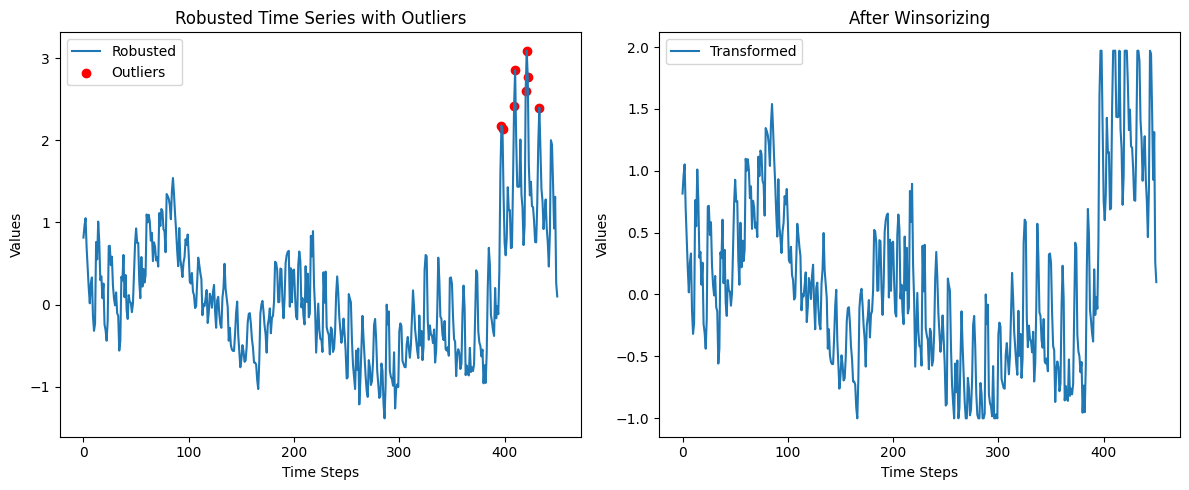

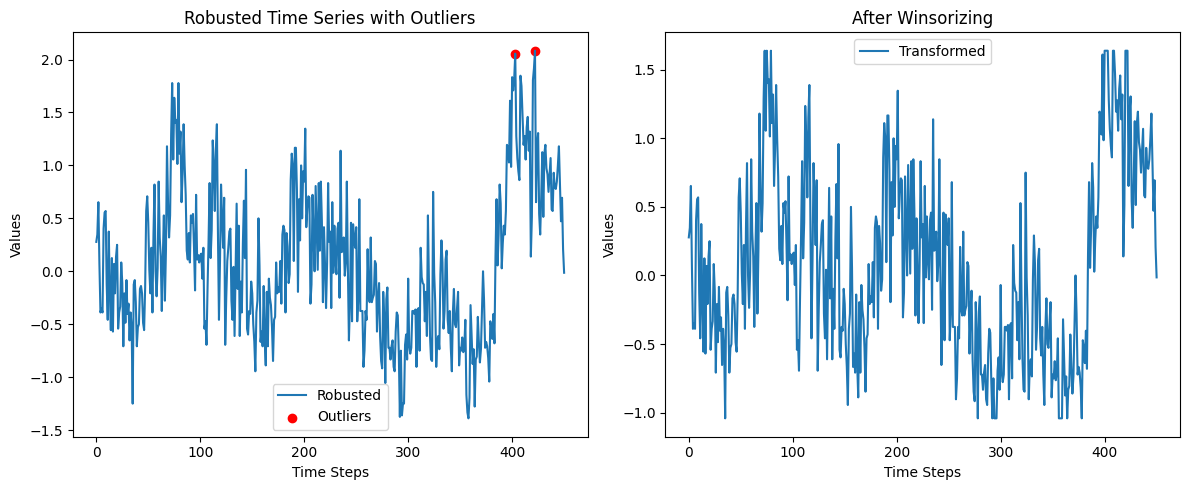

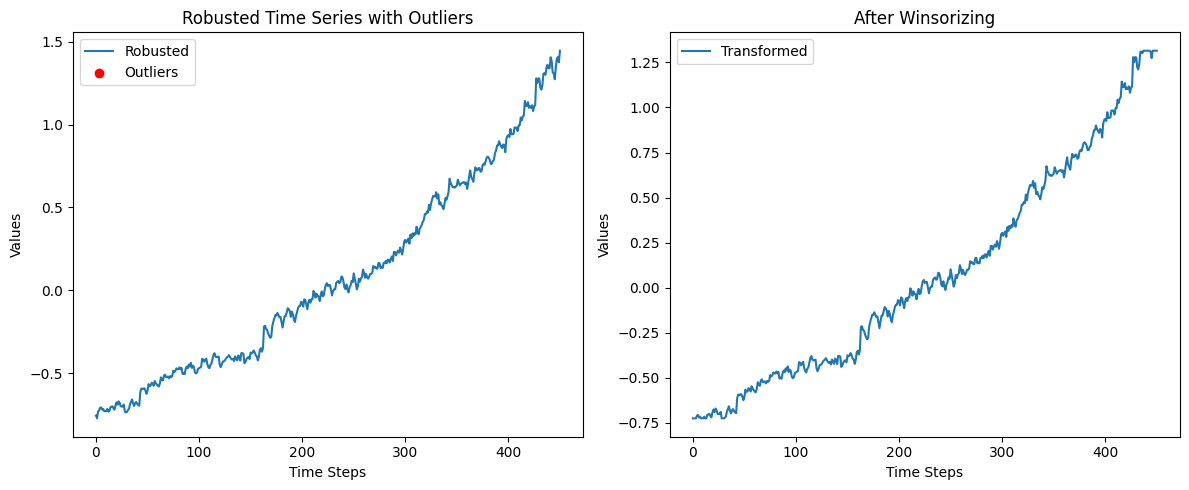

100%|██████████| 48000/48000 [00:08<00:00, 5644.33it/s] 


In [19]:
# Now instead of finding outliers on raw dataset, we first do rubosting, then we find ouliers, and next, we do winsorizing.
# To seee if robusitng can help us or not.

robust_training_data = training_data.copy()
for i in tqdm(range(48000)):
    series = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    robust_series = robust_scale_series(series)
    robust_training_data[i, valid_periods[i, 0]:valid_periods[i, 1]] = robust_series

# Example: Plotting for the first few time series
for i in range(3):
    series = robust_training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    plot_series_before_after(series,label='Robusted', method='winsorize')  # Change to 'winsorize' or 'robust' if needed

winsorized_training_data2 = robust_training_data.copy()
for i in tqdm(range(48000)):
    series = robust_training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    winsorized_series = winsorize_series(series)
    winsorized_training_data2[i, valid_periods[i, 0]:valid_periods[i, 1]] = winsorized_series


####4-8 Distribution of Sequence lenghts

most_common_length: 51
, most_common_count: 6703
, average_length: 198.30022916666667
,median_length: 184.0
, min_length: 24
, max_length: 2776



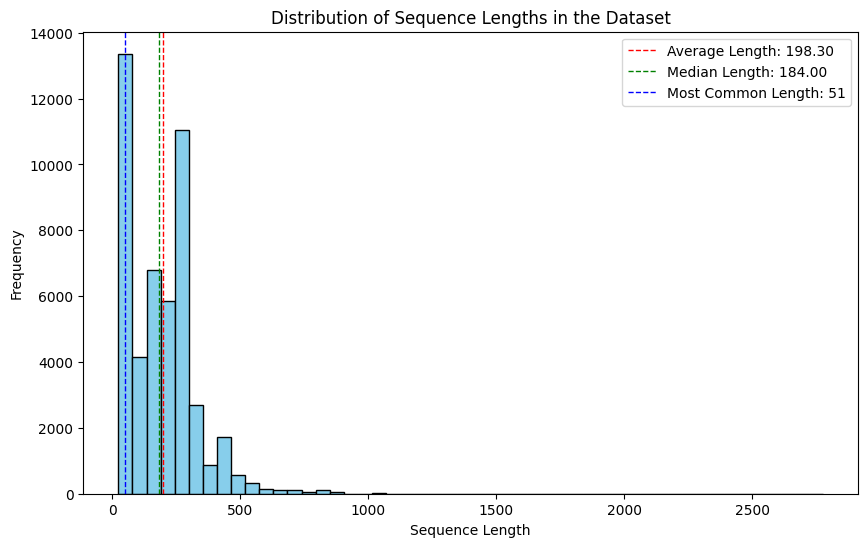

In [22]:
# To get information about the "most common" sequence length, we'll calculate the lengths of the valid sequences
# and then analyze these lengths to find the most common one.

valid_lengths = valid_periods[:, 1] - valid_periods[:, 0]  # Calculate lengths of valid periods
unique_lengths, counts = np.unique(valid_lengths, return_counts=True)  # Get unique lengths and their counts

# Find the most common length
most_common_length = unique_lengths[np.argmax(counts)]
most_common_count = counts[np.argmax(counts)]

# Calculate some basic statistics
average_length = np.mean(valid_lengths)
median_length = np.median(valid_lengths)
min_length = np.min(valid_lengths)
max_length = np.max(valid_lengths)

print(f'most_common_length: {most_common_length}\n, most_common_count: {most_common_count}\n, average_length: {average_length}\n,median_length: {median_length}\n, min_length: {min_length}\n, max_length: {max_length}\n')


# Plotting the distribution of sequence lengths

plt.figure(figsize=(10, 6))
plt.hist(valid_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths in the Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(average_length, color='r', linestyle='dashed', linewidth=1, label=f'Average Length: {average_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median Length: {median_length:.2f}')
plt.axvline(most_common_length, color='b', linestyle='dashed', linewidth=1, label=f'Most Common Length: {most_common_length}')
plt.legend()
plt.show()

####4-9 Check outliers(2)

Here, we try to find those time series which are upper and lower than a threshold and call them outliers2

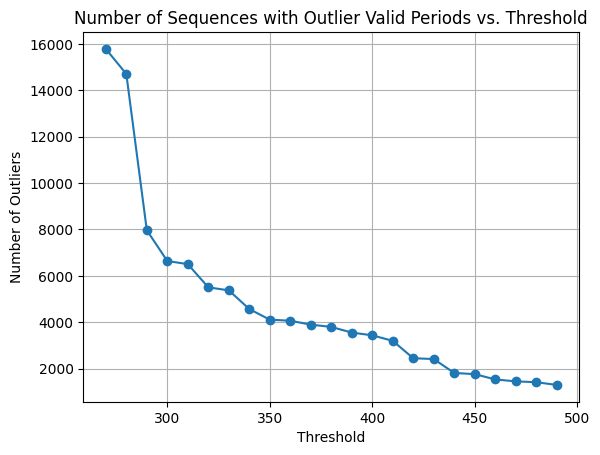

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming valid_periods_df is a DataFrame with columns 'start' and 'end'
valid_durations = valid_periods_df['End index'] - valid_periods_df['Start index']

# Range of threshold values to test
threshold_values = range(270,500 , 10)

# Lists to store counts for each threshold
num_outliers_list = []

# Iterate over threshold values
for threshold in threshold_values:
    # Find indices of sequences with durations exceeding the threshold
    outlier_indices = np.where(valid_durations > threshold)[0]
    # Count the number of outlier sequences
    num_outliers = len(outlier_indices)
    num_outliers_list.append(num_outliers)

# Plot the counts for each threshold
plt.plot(threshold_values, num_outliers_list, marker='o')
plt.title('Number of Sequences with Outlier Valid Periods vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Outliers')
plt.grid(True)
plt.show()

In [24]:
def DeletOutliers(train_df, valid_durations_df, valid_periods_df):
    threshold = 420
    # Assuming training_data_df is your DataFrame
    outlier_indices = list(np.where(valid_durations > threshold)[0])
    print(len(outlier_indices))

    # Drop rows with outlier indices
    new_train_df = training_data_df.drop(outlier_indices)
    new_valid_durations = valid_durations_df.drop(outlier_indices)
    new_valid_periods_df = valid_periods_df.drop(outlier_indices)

    return new_train_df,new_valid_durations, new_valid_periods_df

new_train_df, new_valid_durations, new_valid_periods_df = DeletOutliers(training_data_df, valid_durations, valid_periods_df)
new_train_df.head()

2447


,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411865,0.307129,0.325684,0.361572,0.430420,0.486328,0.450439,0.470703,0.569824,0.570801
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340820,0.522949,0.568359,0.772949,0.681641,0.704590,0.863770,0.727051,0.818359,0.840820
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.631836,0.683105,0.727051,0.822754,0.815918,0.841309,0.878906,0.841309,0.841309,0.834473
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.680176,0.714844,0.738770,0.812500,0.797363,0.828613,0.862305,0.862305,0.876465,0.895020
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120483,0.103394,0.111511,0.117798,0.107910,0.106995,0.098938,0.098022,0.091736,0.095337


In [30]:
# Remove padding from this new_train dataset
new_data = np.array(new_train_df)
new_data_without_padding = []
for i, (start, end) in enumerate(np.array(new_valid_periods_df)):
    new_data_without_padding.append(training_data[i, start:end])

new_data_without_padding_df = pd.DataFrame(new_data_without_padding)

45553it [00:00, 250492.47it/s]


In [31]:
C.head()

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,0.281481,0.262037,0.238889,0.224074,0.354630,0.272222,0.304630,0.283333,0.400926,0.668519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.016000,0.000000,0.056000,0.308000,0.228000,0.148000,0.188000,0.032000,0.160000,0.168000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.628043,0.622490,0.626932,0.609810,0.624896,0.644424,0.658862,0.640814,0.635817,0.628690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
new_data_without_padding_df.shape

(45553, 420)

####4-10 Hyperparameters

In [67]:
window_size = 50
epochs = 200
batch_size = 128

####4-11 Check Stationary
We can check stationarity using the following:

1. **ACF and PACF plots:**

 If the time series is **stationary**, the ACF/PACF plots will show a quick **drop-off in correlation** after a small amount of lag between points.
2. **Plotting Rolling Statistics:**

  We can plot the moving average or moving variance and see if it varies with time.If **Mean and SD are relatively constent** with respect to time, time series is **stationary**
3. **Augmented Dickey-Fuller Test:**

  This is one of the statistical tests for checking stationarity. Here if **p-value is less than a thershold called alpha**, time series is **stationary**

4. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**
    
    Here if **p-value is less than a thershold called alpha**, time series is **stationary**


In [34]:
def test_stationarity(ts_values, plot_name, alpha=0.01):
    # ts is denoted for time series


    #Determing rolling statistics
    plt.figure(figsize=(8,8))
    plt.subplot(211)
    plot_acf(ts_values, ax=plt.gca(), lags = window_size)
    plt.subplot(212)
    plot_pacf(ts_values, ax=plt.gca(), lags = window_size)
    plt.show()

    print('-'*100)
    #Plot rolling statistics:
    plt.figure(figsize=(15,8))
    rolmean = np.convolve(ts_values, np.ones(window_size)/window_size, mode='valid')
    rolstd = np.sqrt(np.convolve(ts_values**2, np.ones(window_size)/window_size, mode='valid') -
                        np.convolve(ts_values, np.ones(window_size)/window_size, mode='valid')**2)

    orig = plt.plot(ts_values, color='blue',label= plot_name)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation  ')
    plt.show(block=False)

    print('-'*100)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    result_adf = adfuller(ts_values)
    Dickey_Fuller_p_value = result_adf[1]
    print('p-value:', Dickey_Fuller_p_value)

    print('-'*100)
    print ('Results of kpss Test:')
    result_kpss = kpss(ts_values)
    kpss_p_value = result_kpss[1]
    print('p-value:', kpss_p_value)


    print('-'*100)
    if (Dickey_Fuller_p_value <= 0.02) & (kpss_p_value <=0.02):
      print('This time series is stationary')
      print('-'*100)

    else:
      print('This time series is not stationary')
      print('-'*100)

    return rolmean


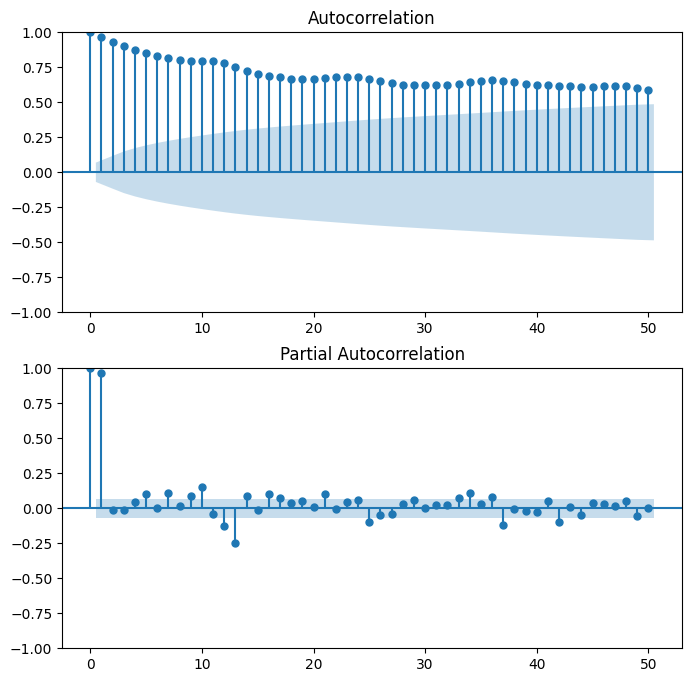

----------------------------------------------------------------------------------------------------


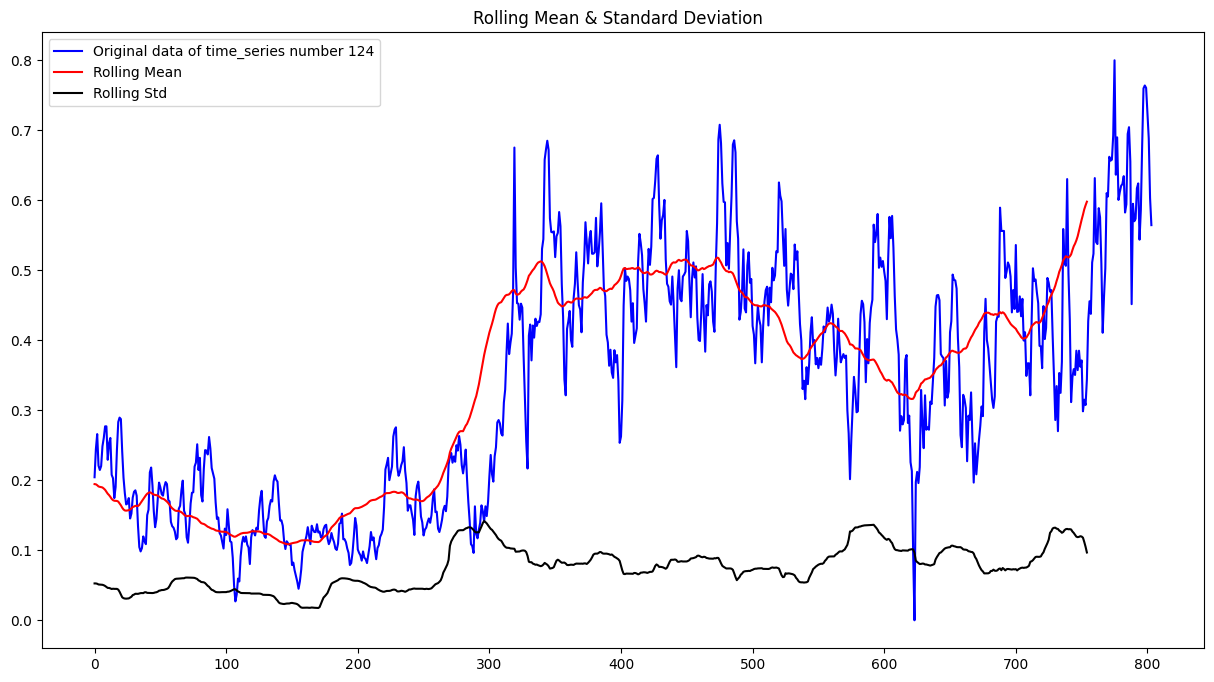

----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
p-value: 0.6154929515438404
----------------------------------------------------------------------------------------------------
Results of kpss Test:
p-value: 0.01
----------------------------------------------------------------------------------------------------
This time series is not stationary
----------------------------------------------------------------------------------------------------


In [35]:
training_data_without_padding_np = np.array(data_without_padding)
which_row_you_want_to_check =  124 # You can change it and see different time series
ts_values = training_data_without_padding_np[which_row_you_want_to_check]
rolmean = test_stationarity(ts_values,plot_name=f'Original data of time_series number {which_row_you_want_to_check}')

####4-12 How to  make time series stationary


#####4-12-1 By removing roll mean from original

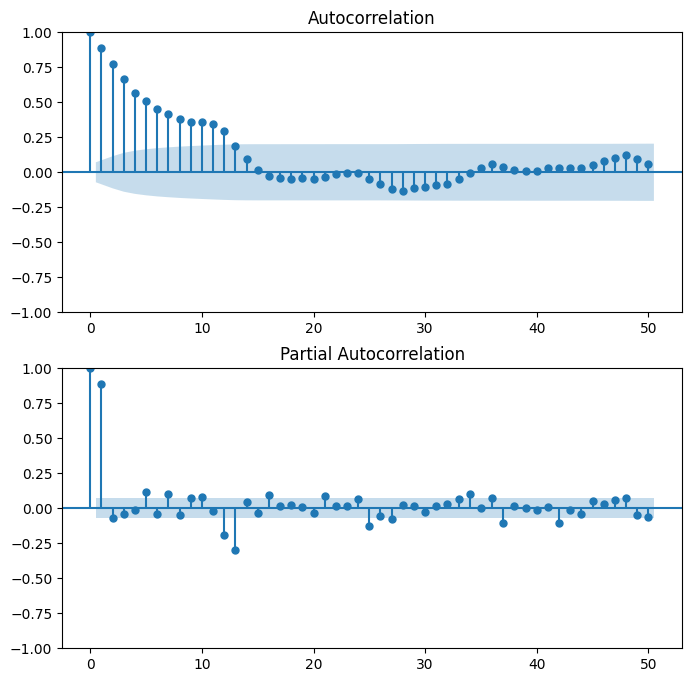

----------------------------------------------------------------------------------------------------


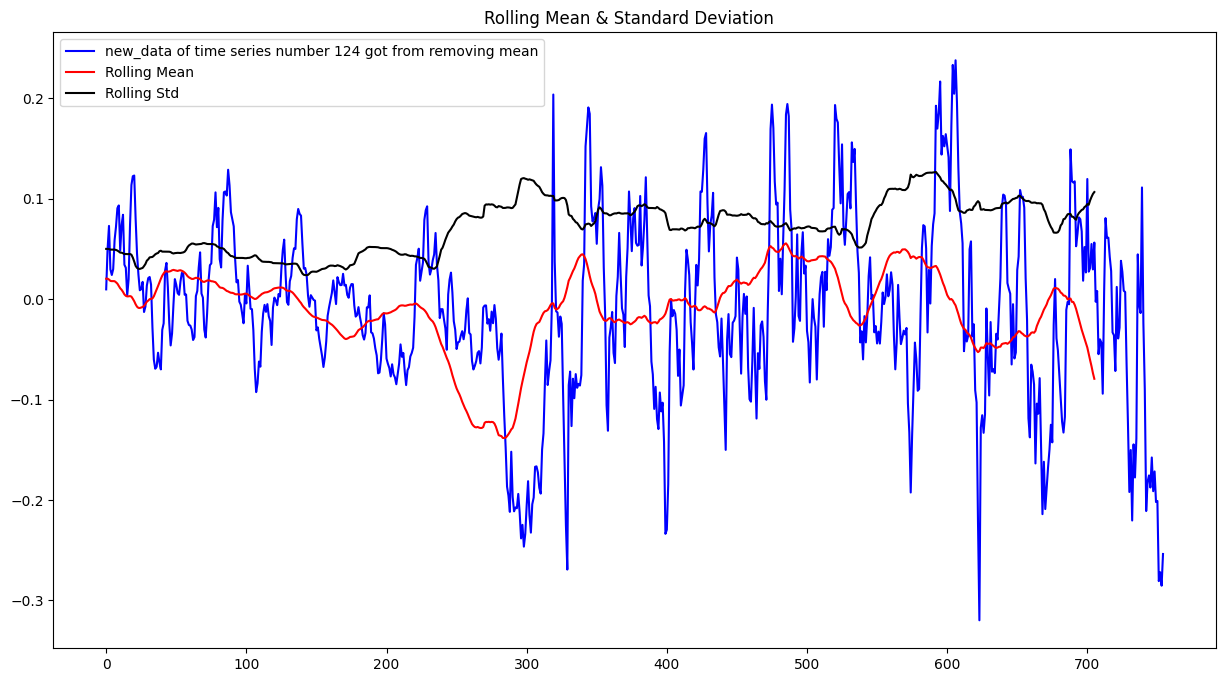

----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
p-value: 0.0004473738216266607
----------------------------------------------------------------------------------------------------
Results of kpss Test:
p-value: 0.1
----------------------------------------------------------------------------------------------------
This time series is not stationary
----------------------------------------------------------------------------------------------------


array([ 2.04141274e-02,  2.05058172e-02,  1.96216066e-02,  1.82493075e-02,
        1.80083102e-02,  1.80493075e-02,  1.79515235e-02,  1.68606648e-02,
        1.55108033e-02,  1.32675900e-02,  1.08867036e-02,  9.39279778e-03,
        7.30914127e-03,  4.81523546e-03,  3.37368421e-03,  2.81024931e-03,
        2.89916898e-03,  3.12576177e-03,  2.59196676e-03,  4.30470914e-04,
       -1.98670360e-03, -5.05567867e-03, -7.42077562e-03, -8.61135734e-03,
       -8.74349030e-03, -8.24432133e-03, -7.73130194e-03, -6.61994460e-03,
       -4.78033241e-03, -2.50498615e-03, -1.34016620e-03,  5.81717452e-05,
        4.13573407e-04,  7.53462604e-04,  2.88614958e-03,  6.22188366e-03,
        9.75235457e-03,  1.31617729e-02,  1.68063712e-02,  2.03357341e-02,
        2.34648199e-02,  2.56617729e-02,  2.75944598e-02,  2.78235457e-02,
        2.74362881e-02,  2.75775623e-02,  2.80047091e-02,  2.88163435e-02,
        2.92110803e-02,  2.88318560e-02,  2.85191136e-02,  2.81476454e-02,
        2.86941828e-02,  

In [37]:
diff = pd.DataFrame(ts_values) - pd.DataFrame(rolmean)
diff.dropna(inplace=True)

# Let's check it again to understand it is stationary now or not
test_stationarity(diff.transpose().to_numpy()[0],plot_name=f'new_data of time series number {which_row_you_want_to_check} got from removing mean')

#####4-12-2 By Exponentially weighted moving average
  To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
We take a ‘weighted moving average’ where more recent values are given a higher weight.
There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

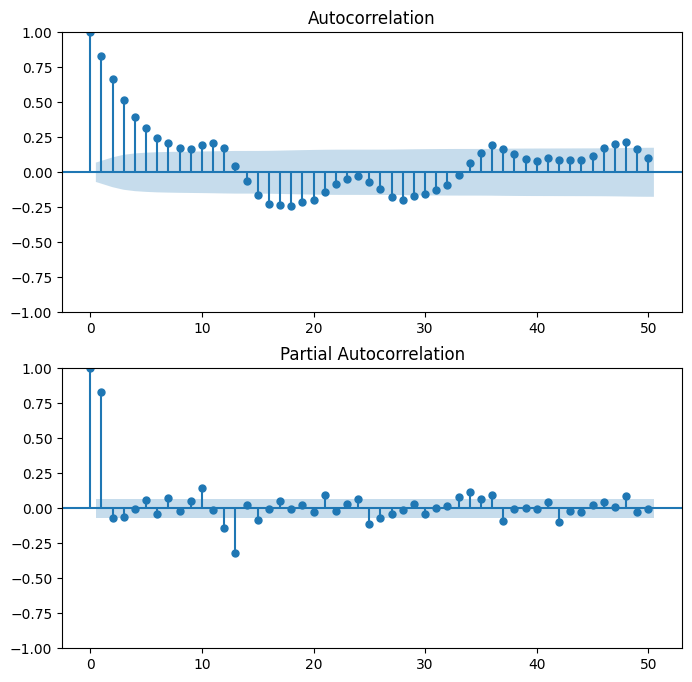

----------------------------------------------------------------------------------------------------


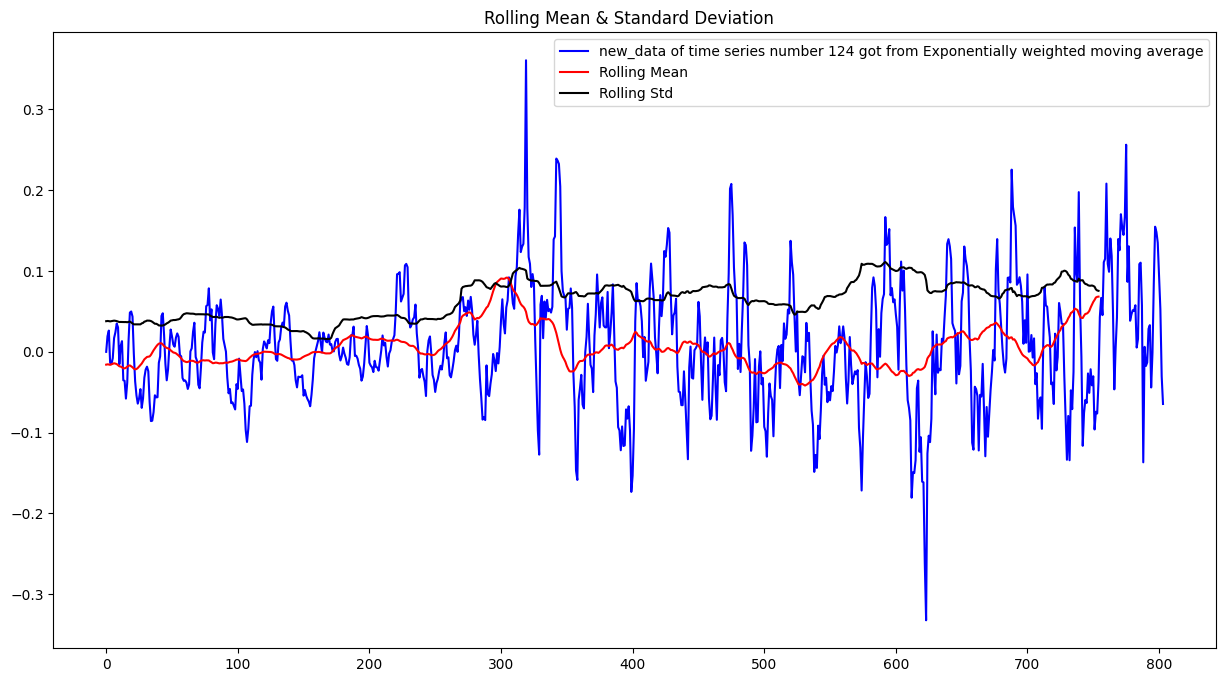

----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
p-value: 1.422247780783674e-12
----------------------------------------------------------------------------------------------------
Results of kpss Test:
p-value: 0.1
----------------------------------------------------------------------------------------------------
This time series is not stationary
----------------------------------------------------------------------------------------------------


array([-1.58475960e-02, -1.54624476e-02, -1.56721173e-02, -1.60706299e-02,
       -1.54489846e-02, -1.46881429e-02, -1.41591346e-02, -1.45775853e-02,
       -1.51743250e-02, -1.65200236e-02, -1.78442545e-02, -1.82466349e-02,
       -1.91555630e-02, -2.03380597e-02, -2.04390609e-02, -1.97097132e-02,
       -1.84642712e-02, -1.72112361e-02, -1.67708444e-02, -1.78714730e-02,
       -1.90934834e-02, -2.07823403e-02, -2.16349901e-02, -2.12938379e-02,
       -1.99860218e-02, -1.82045238e-02, -1.65720195e-02, -1.45186672e-02,
       -1.19739367e-02, -9.25117870e-03, -7.82898571e-03, -6.33850980e-03,
       -5.98492367e-03, -5.68475436e-03, -3.74717066e-03, -8.78983088e-04,
        1.88924818e-03,  4.26912729e-03,  6.63849745e-03,  8.66230769e-03,
        1.01057660e-02,  1.05338027e-02,  1.06484124e-02,  9.13055765e-03,
        7.14927045e-03,  5.81904072e-03,  4.84846145e-03,  4.30279892e-03,
        3.40492893e-03,  1.85683953e-03,  5.04218896e-04, -7.95697572e-04,
       -1.14236013e-03, -

In [38]:
expwighted_avg =  pd.DataFrame(ts_values).ewm(halflife=10).mean()
diff = pd.DataFrame(ts_values) - expwighted_avg
diff.dropna(inplace=True)
test_stationarity(diff.transpose().to_numpy()[0],plot_name=f'new_data of time series number {which_row_you_want_to_check} got from Exponentially weighted moving average')

#####4-12-3 By Decomposition

  In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

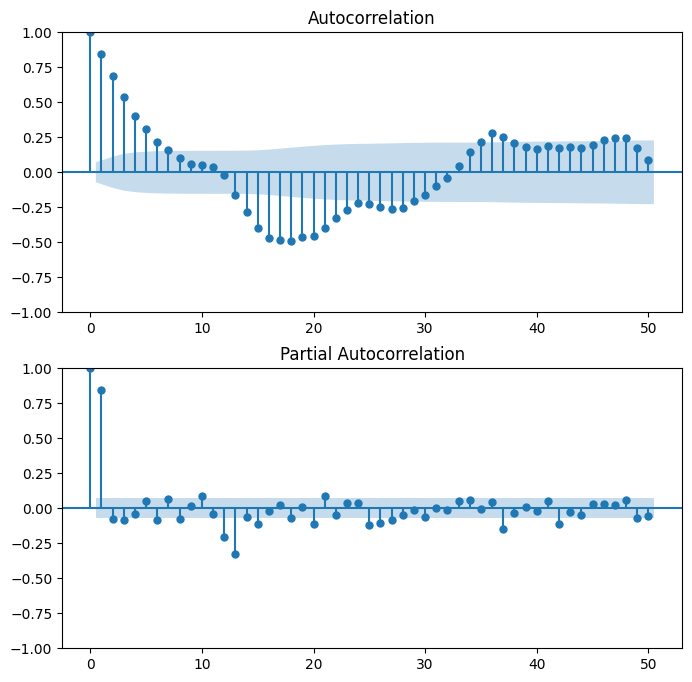

----------------------------------------------------------------------------------------------------


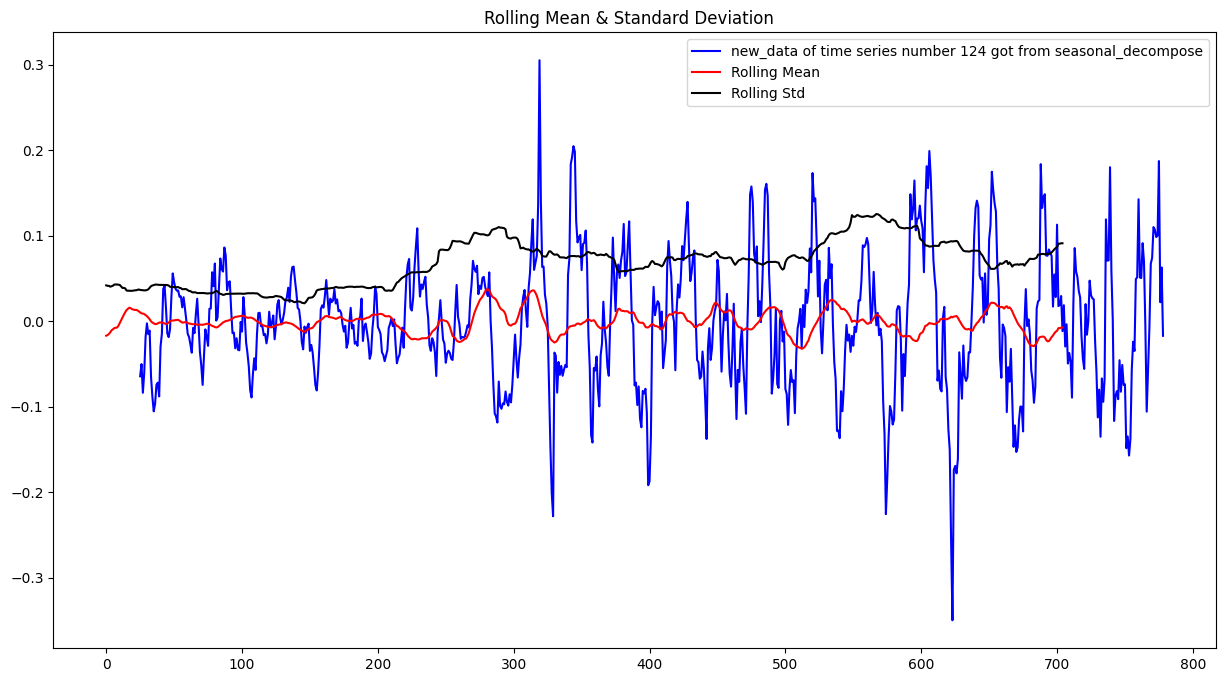

----------------------------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
p-value: 2.7186387201246838e-12
----------------------------------------------------------------------------------------------------
Results of kpss Test:
p-value: 0.1
----------------------------------------------------------------------------------------------------
This time series is not stationary
----------------------------------------------------------------------------------------------------


array([-1.69707756e-02, -1.62590028e-02, -1.49634349e-02, -1.29930748e-02,
       -1.06346260e-02, -9.44418283e-03, -8.04404432e-03, -7.72700831e-03,
       -7.41828255e-03, -5.31897507e-03, -2.09016620e-03,  1.23185596e-03,
        4.32396122e-03,  7.53628809e-03,  1.05088643e-02,  1.29932133e-02,
        1.45013850e-02,  1.57259003e-02,  1.52300554e-02,  1.41249307e-02,
        1.35425208e-02,  1.31939058e-02,  1.31681440e-02,  1.26868421e-02,
        1.14368421e-02,  1.03016620e-02,  9.14709141e-03,  8.94667590e-03,
        8.37257618e-03,  7.15637119e-03,  5.84099723e-03,  4.19709141e-03,
        2.25941828e-03, -8.46260388e-05, -1.62326870e-03, -2.51149584e-03,
       -3.35595568e-03, -3.29155125e-03, -2.55775623e-03, -1.62465374e-03,
       -1.58628809e-03, -1.43282548e-03, -1.91703601e-03, -2.74404432e-03,
       -3.19944598e-03, -2.79750693e-03, -1.54099723e-03, -1.89889197e-04,
        5.72714681e-04,  8.98476454e-04,  8.40304709e-04,  1.30872576e-03,
        1.40914127e-03,  

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(pd.DataFrame(ts_values),period= window_size)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
diff = residual
diff.dropna(inplace=True)
test_stationarity(diff,plot_name=f'new_data of time series number {which_row_you_want_to_check} got from seasonal_decompose')

####4-13 Make not-stationary time series stationary
Here, we check two test for each time series and try to make them stationary with Decomposition model

In [40]:
def create_stationarity(training_data_without_padding,window_size=window_size,alpha=0.02):
    # ts is denoted for time series
    output = []
    no_rows = training_data_without_padding_np.size

    for which_row_you_want_to_check in tqdm(range(no_rows)):
      ts_values = training_data_without_padding_np[which_row_you_want_to_check]

      # Get Dickey_Fuller_p_value
      Dickey_Fuller_p_value = adfuller(ts_values)[1]
      # Get kpss p -value

      if len(ts_values)>=100: # since for kpss, we need at least 100 observations
        kpss_p_value = kpss(ts_values,nlags=window_size)[1]

        if (Dickey_Fuller_p_value > alpha) | (kpss_p_value >alpha):
          # it means it is not  stationary, so  do use decomposition
          decomposition = seasonal_decompose(pd.DataFrame(ts_values),period= window_size)
          residual = decomposition.resid
          diff = residual
          diff.dropna(inplace=True)

          # Save this diff value as new_data to work on

          output.append(np.array(diff))


        else:
          output.append(training_data_without_padding_np[which_row_you_want_to_check])

      else:

        if (Dickey_Fuller_p_value > alpha) | (kpss_p_value >alpha):
          # it means it is not  stationary, so  do use expwighted_avg
          expwighted_avg =  pd.DataFrame(ts_values).ewm(halflife=10).mean()
          diff = pd.DataFrame(ts_values) - expwighted_avg
          diff.dropna(inplace=True)

          # Save this diff value as new_data to work on
          output.append(np.squeeze(np.array(diff), axis=1))

        else:
          output.append(training_data_without_padding_np[which_row_you_want_to_check])

    return list(output)


In [41]:
stationary_data_without_padding = create_stationarity(data_without_padding,window_size)

100%|██████████| 48000/48000 [16:39<00:00, 48.02it/s]


###5- Build_Sequence

In [42]:
def build_sequences(original_dataset, integer_labels, window=20, stride=10, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    predictions = []
    labels = []
    for i, row in enumerate(original_dataset):
        padding_len = window - len(original_dataset[i])%window
        original_dataset[i] = np.pad(original_dataset[i], (padding_len, 0), mode='constant', constant_values=0)
        for idx in np.arange(0,len(original_dataset[i])-window-telescope,stride):
            dataset.append(original_dataset[i][idx:idx+window].reshape((window, 1)))
            predictions.append(original_dataset[i][idx+window:idx+window+telescope].reshape((telescope, 1)))
            labels.append(integer_labels[i])
    dataset = np.array(dataset)
    predictions = np.array(predictions)
    labels = np.array(labels)
    return dataset, predictions, labels

In [60]:
winsorized_training_data1_without_padding = []
for i, (start, end) in enumerate(valid_periods):
    winsorized_training_data1_without_padding.append(winsorized_training_data1[i, start:end])

winsorized_training_data2_without_padding = []
for i, (start, end) in enumerate(valid_periods):
    winsorized_training_data2_without_padding.append(winsorized_training_data2[i, start:end])

winsorized_training_data2_without_padding = []
for i, (start, end) in enumerate(valid_periods):
    winsorized_training_data2_without_padding.append(winsorized_training_data2[i, start:end])

In [61]:
# Here we make x_train and y_train based different datasets we have created

# For raw dataset
X_train1, y_train1, labels1 = build_sequences(data_without_padding, categories, window=window_size, stride=10, telescope=18)

#  For winsorized dataset which we removed outliers1 from
X_train2, y_train2, labels2 = build_sequences(winsorized_training_data1_without_padding, categories, window=window_size, stride=10, telescope=18)


# For winsorized dataset after robusitng
X_train3, y_train3, labels3 = build_sequences(winsorized_training_data2_without_padding, categories, window=window_size, stride=10, telescope=18)

# For raw dataset which we removed outliers2 from
X_train4, y_train4, labels4 = build_sequences(new_data_without_padding, categories, window=window_size, stride=10, telescope=18)


# For stationary raw dataset
X_train5, y_train5, labels5 = build_sequences(stationary_data_without_padding, categories, window=window_size, stride=10, telescope=18)



((638332, 50, 1), (638332, 18, 1), (638332,))

In [62]:
# Since all datasets have the same input, output shape, we have:
input_shape = X_train1.shape[1:]
output_shape = y_train1.shape[1:]
print('x_train.shape:',X_train1.shape, 'y_train.shape:',y_train1.shape,'labels.shape',labels1.shape)
print(f'input_shape:{input_shape} and output_shape:{output_shape}')

x_train.shape: (1039010, 50, 1) y_train.shape: (1039010, 18, 1) labels.shape (1039010,)
input_shape:(50, 1) and output_shape:(18, 1)


###6- Model Number 1

####6-1 Define Model

In [63]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 50, 128)           33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 50, 128)           49280     
                                                                 
 output_layer (Conv1D)       (None, 50, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

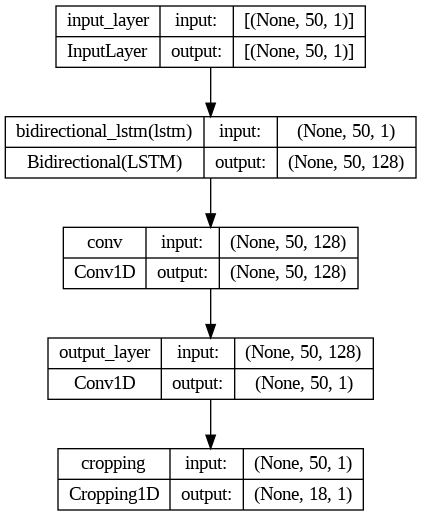

In [64]:
model1 = build_CONV_LSTM_model(input_shape, output_shape)
model1.summary()
tfk.utils.plot_model(model1, expand_nested=True, show_shapes=True)

####6-2 Fit Model on X-train1, y-train1

In [ ]:
# Train the model
history1 = model1.fit(
    x = X_train1,
    y = y_train1,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
5633/5633 [==============================] - 71s 11ms/step - loss: 0.0183 - val_loss: 0.0203 - lr: 0.0010
Epoch 2/200
5633/5633 [==============================] - 59s 11ms/step - loss: 0.0149 - val_loss: 0.0192 - lr: 0.0010
Epoch 3/200
5633/5633 [==============================] - 60s 11ms/step - loss: 0.0140 - val_loss: 0.0190 - lr: 0.0010
Epoch 4/200
5633/5633 [==============================] - 59s 10ms/step - loss: 0.0136 - val_loss: 0.0182 - lr: 0.0010
Epoch 5/200
5633/5633 [==============================] - 60s 11ms/step - loss: 0.0133 - val_loss: 0.0184 - lr: 0.0010
Epoch 6/200
5633/5633 [==============================] - 59s 11ms/step - loss: 0.0131 - val_loss: 0.0178 - lr: 0.0010
Epoch 7/200
5633/5633 [==============================] - 59s 11ms/step - loss: 0.0130 - val_loss: 0.0176 - lr: 0.0010
Epoch 8/200
5633/5633 [==============================] - 59s 10ms/step - loss: 0.0128 - val_loss: 0.0177 - lr: 0.0010
Epoch 9/200
5633/5633 [==============================] -

####6-3 Fit Model on X-train2, y-train2

In [ ]:
model1_2 = build_CONV_LSTM_model(input_shape, output_shape)

In [ ]:
# Train the model
history2 = model1_2.fit(
    x = X_train2,
    y = y_train2,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

####6-4 Fit Model on X-train3, y-train3

In [ ]:
model1_3 = build_CONV_LSTM_model(input_shape, output_shape)

In [ ]:
# Train the model
history3 = model1_3.fit(
    x = X_train3,
    y = y_train3,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

####6-5 Fit Model on X-train4, y-train4

In [65]:
model1_4 = build_CONV_LSTM_model(input_shape, output_shape)

In [ ]:
# Train the model
history4 = model1_4.fit(
    x = X_train4,
    y = y_train4,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
 531/4744 [==>...........................] - ETA: 11:25 - loss: 0.0313

####6-6 Fit Model on X-train5, y-train5

In [ ]:
model1_5 = build_CONV_LSTM_model(input_shape, output_shape)

In [ ]:
# Train the model
history5 = model1_5.fit(
    x = X_train5,
    y = y_train5,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history